# Explore nationalities in relation to evolution over time

In [1]:
import sqlite3 as sql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Create a Pandas dataframe from a SQL query

In [3]:
### Define the path to the file (a string in a variable 'db_file')
# if the data directory label is at the same level as the notebook,
# then the path is 'data/astronomers_import.db'
db_file_address = '../../data/astronomers_import.db'

In [4]:
### Create a connection to the SQLite database of your repository
# Beware : if the database does not exist at the specified address (db_file_address)
# it will be created and will be empty. Therefore, carefully check the database address
try:
    cn = sql.connect(db_file_address)    
except Exception as e:
    # if the connection does not work
    # an error message is raised
    print(e)    


In [5]:
### This ist the query that produces the data to be analysed.
# It has to be adapted to each use case
q1 = """
WITH tw1 AS (
SELECT natio_code, SUM(eff) as effectif_tot
from code_nationality_country
GROUP BY natio_code ),
--count each person just once
tw2 AS (
SELECT subject_uri, COUNT(*) eff, min(natio_country) natio_country, max(birthyear) birthyear
FROM dbp_person_countries dpc 
group by subject_uri)
SELECT tw2.birthyear, tw1.natio_code, tw1.effectif_tot
FROM tw2
   JOIN code_nationality_country cnc ON cnc.natio_country = tw2.natio_country 
   JOIN tw1 ON tw1.natio_code = cnc.natio_code 
WHERE LENGTH(cnc.natio_code) > 0
ORDER BY birthyear ;     
"""

In [6]:
### This instruction executes the query 
# then closes the connection to the database 
c_df= pd.read_sql_query(q1, cn)
cn.close()
# Inspect the first lines
print(c_df.head())

   birthyear natio_code  effectif_tot
0       1380   Austrian            72
1       1404    Italian           219
2       1423    Italian           219
3       1423   Austrian            72
4       1436     German           369


In [7]:
### Inspect maximum and minimum birth dates
print(c_df.birthyear.min(), c_df.birthyear.max())

1380 1993


In [9]:
### Exclude rows with 10 or less persons
c_df = c_df[c_df.effectif_tot > 10].sort_values(by=['natio_code','birthyear'])
print(c_df.tail())

      birthyear natio_code  effectif_tot
2027       1953      Swiss            56
2138       1961      Swiss            56
2162       1963      Swiss            56
2189       1966      Swiss            56
2195       1966      Swiss            56


In [12]:
### Count how many persons you have per country (natio_code): distribution
dc_df = c_df[['natio_code','effectif_tot']].groupby('natio_code').max()
dc_df

,effectif_tot
natio_code,
American,664
Argentinian,18
Austrian,72
British,300
Dutch,94
French,329
German,369
Indian,112
Italian,219


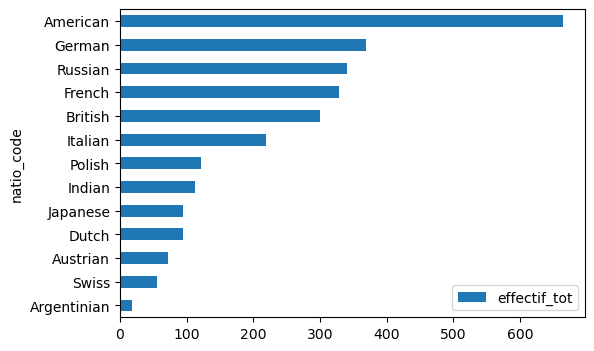

In [15]:
### Plot the distribution
dc_df.sort_values(by='effectif_tot').plot(kind='barh', figsize=(6,4))
plt.show()

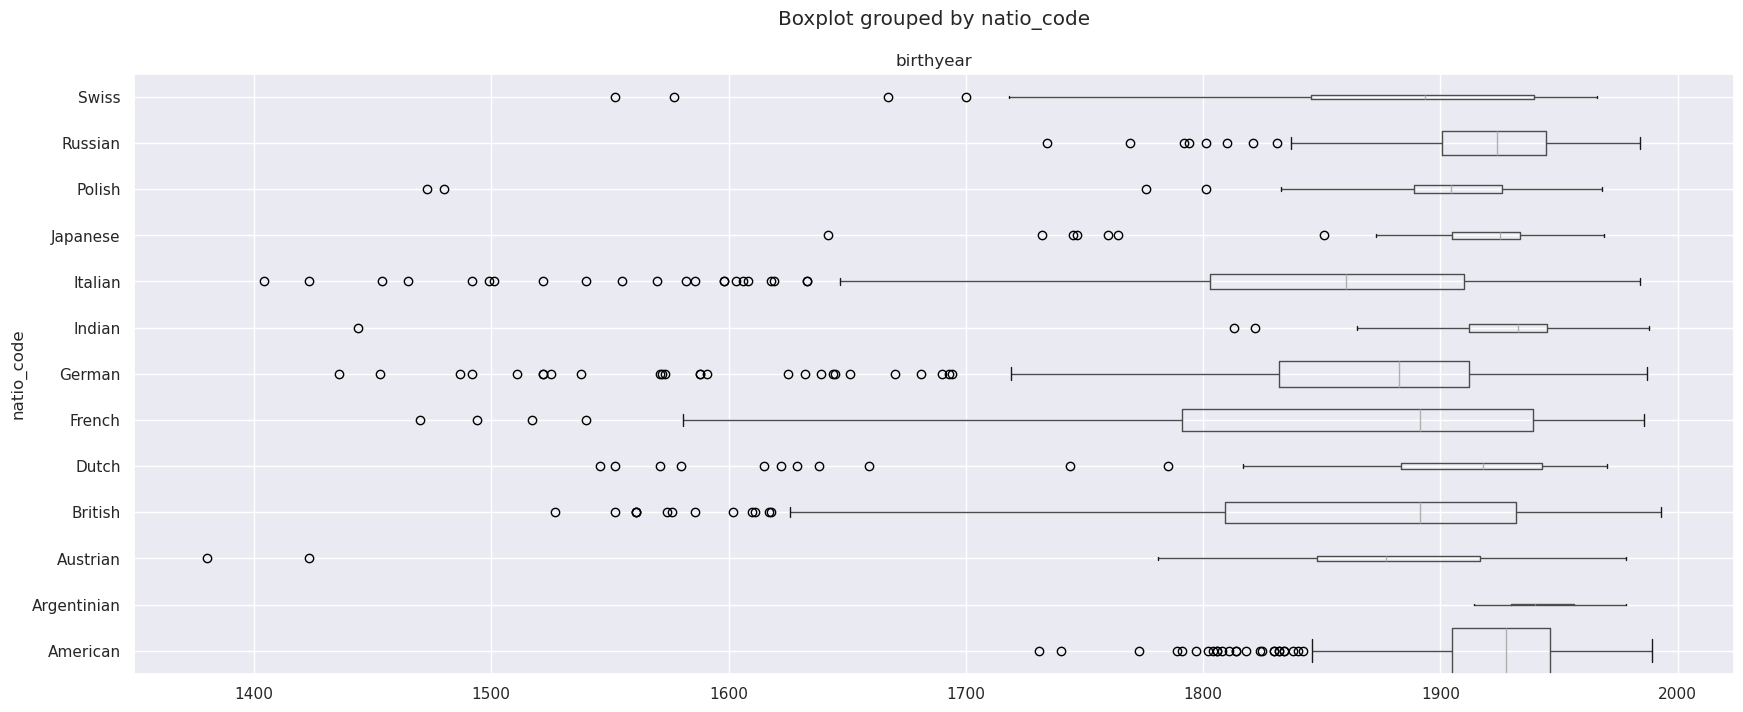

In [49]:
total = float(sum(counts))
widths = [c/max(counts) for c in counts] 
c_df.sort_values(by='natio_code', ascending=True).boxplot(column='birthyear', by='natio_code',  
          vert=False, widths=widths, figsize=(20,8))
plt.show()

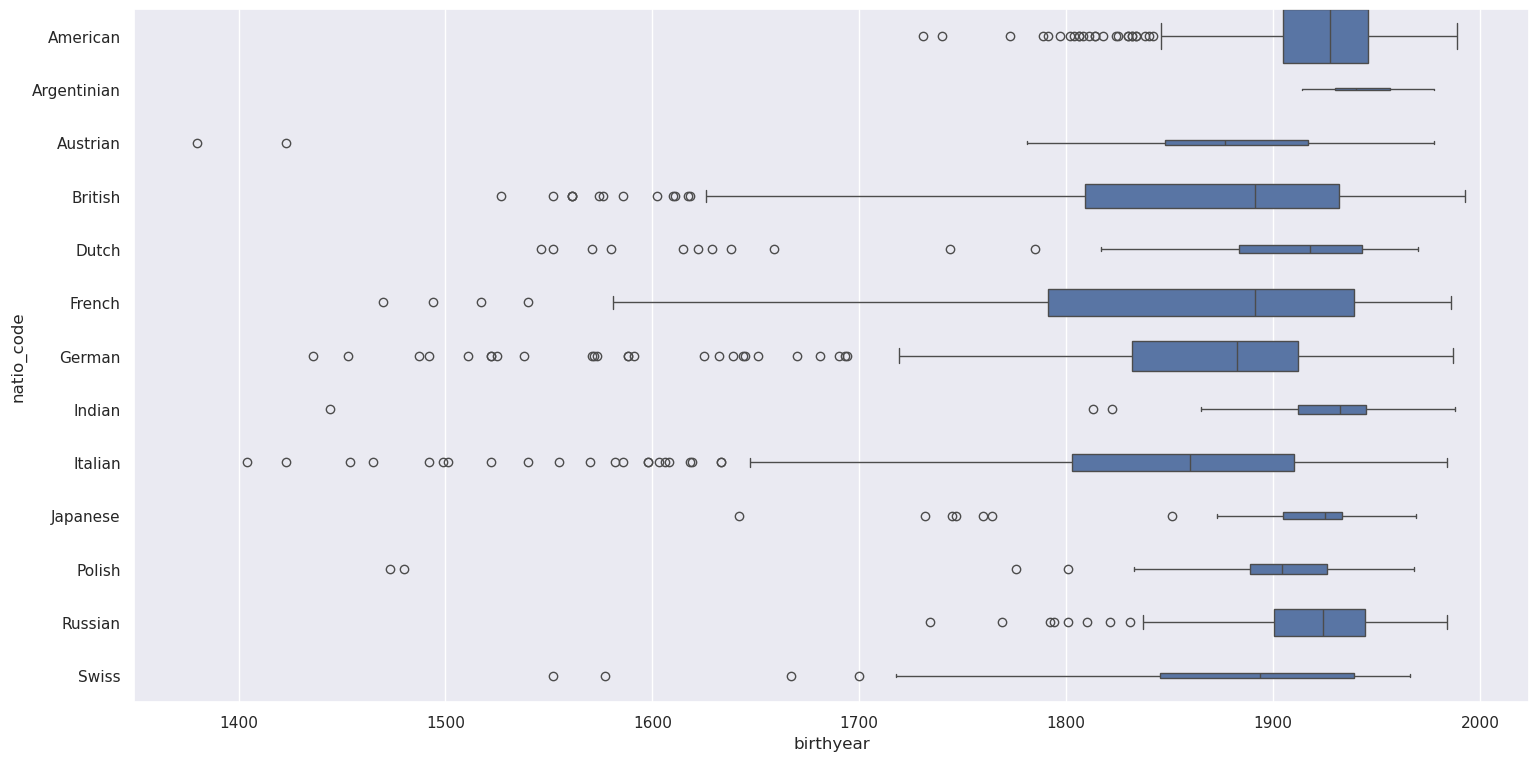

In [47]:
sns.set_theme(rc={'figure.figsize':(18,9)})

counts= dc_df.effectif_tot
total = float(sum(counts))
widths = [c/max(counts) for c in counts] 
sns.boxplot(y=c_df["natio_code"], x=c_df.birthyear, width=widths)
plt.show()

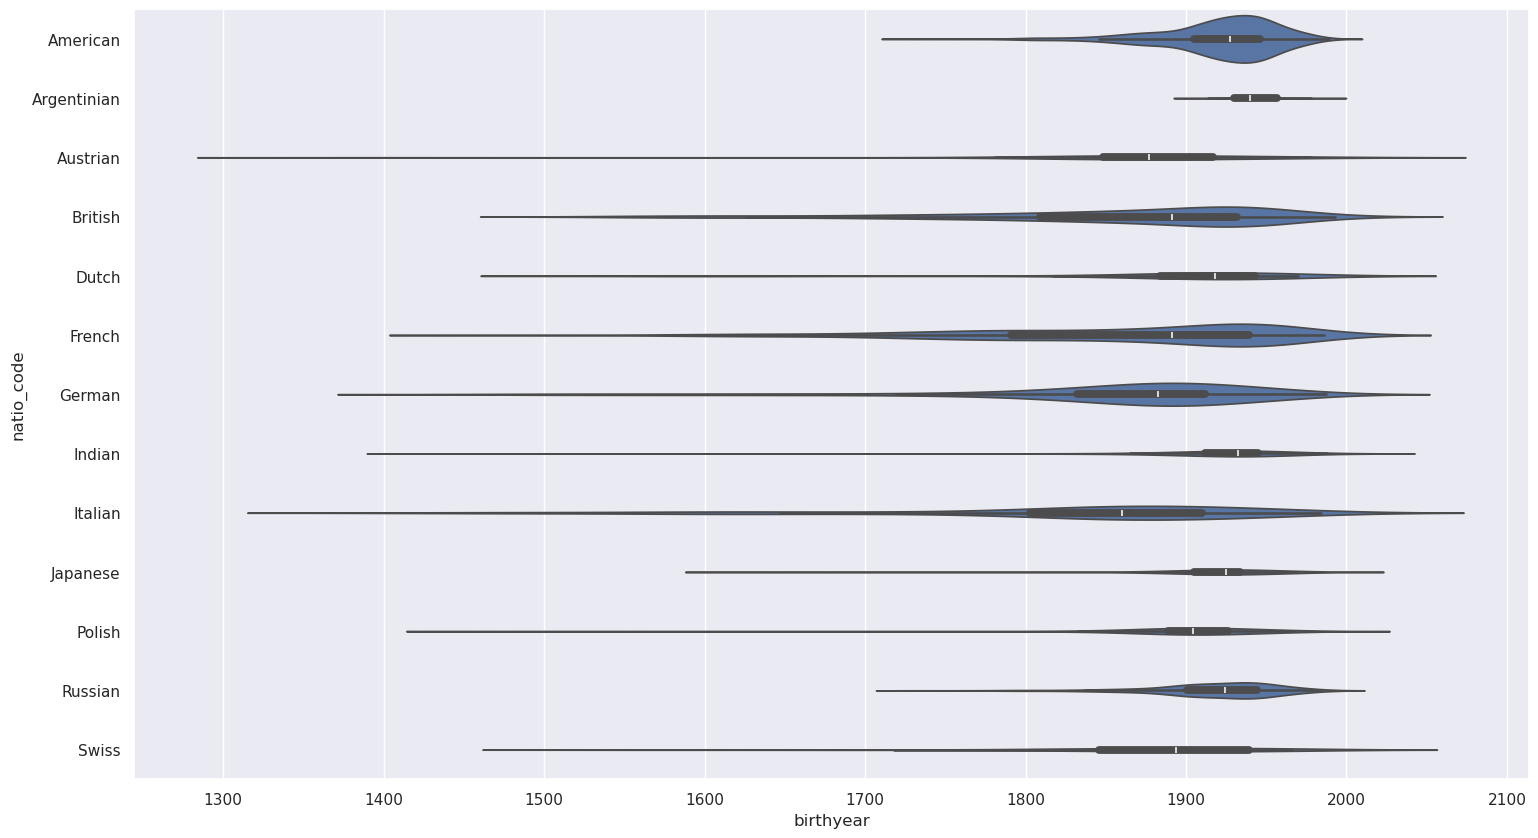

In [19]:
### Allows to inspect identity zones but not the proportion to global number
sns.set_theme(rc={'figure.figsize':(18,10)})

## noter que "density_norm" remplace "scale='count'"
sns.violinplot(y='natio_code', x='birthyear', data=c_df, density_norm='count')
plt.show()

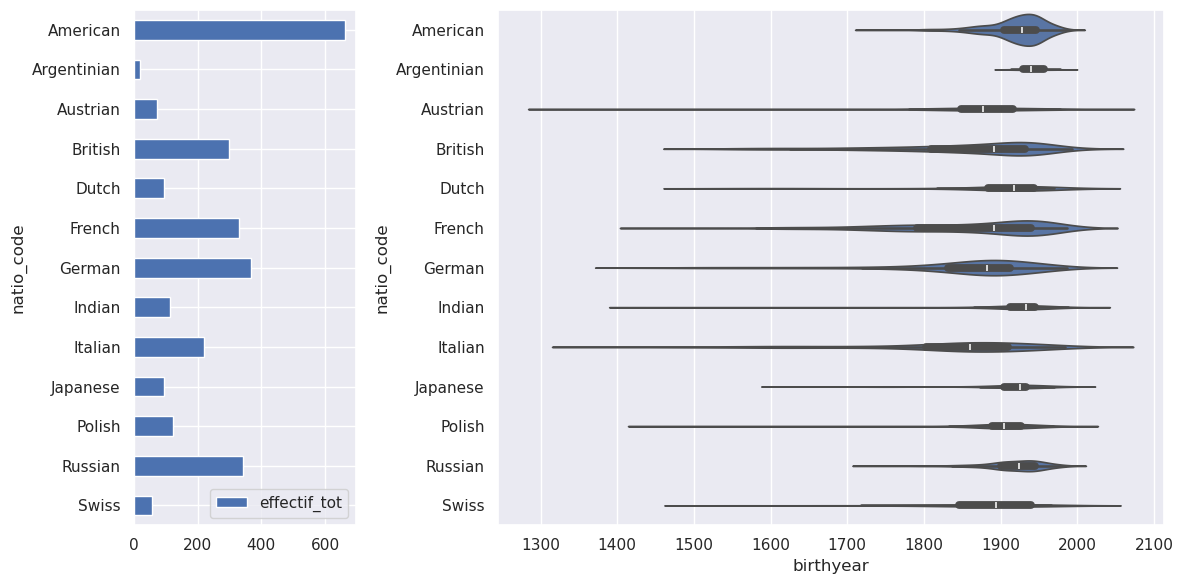

In [46]:
fig, (ax1, ax2) = plt.subplots(ncols=2, width_ratios=[1, 3])

gd_df = c_df[['natio_code','effectif_tot']].groupby(by=['natio_code']).max()\
      .sort_index(ascending=False).plot(kind='barh', figsize=(12,6), ax=ax1)

ax2 = sns.violinplot(y='natio_code', x='birthyear', data=c_df, density_norm='count')

# évite les superpositions
fig.tight_layout()

plt.savefig('pictures/natio_code_birth_year_20241209.png')
plt.show()